In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import yfinance as yf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime,timedelta
from copy import deepcopy as dc

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [95]:
ticker="AAPL"
current_date = datetime.now()
data: pd.DataFrame = yf.download(ticker,
                                 start=current_date - timedelta(days=3625),
                                 end=current_date,
                                 interval="1d")
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-08-14,24.332500,24.392500,24.200001,24.375000,21.667789,112464000
2014-08-15,24.475000,24.547501,24.215000,24.495001,21.774466,195804000
2014-08-18,24.622499,24.842501,24.495001,24.790001,22.036694,190288000
2014-08-19,24.852501,25.170000,24.830000,25.132500,22.341154,277596000
2014-08-20,25.110001,25.272499,24.987499,25.142500,22.350044,210796000
...,...,...,...,...,...,...
2024-07-11,231.389999,232.389999,225.770004,227.570007,227.570007,64710600
2024-07-12,228.919998,232.639999,228.679993,230.539993,230.539993,53008200
2024-07-15,236.479996,237.229996,233.089996,234.399994,234.399994,62631300


In [96]:
data = data.reset_index()
data["Date"] = pd.to_datetime(data["Date"])
data = data.drop(columns=["Adj Close"])
data

,Date,Open,High,Low,Close,Volume
0,2014-08-14,24.332500,24.392500,24.200001,24.375000,112464000
1,2014-08-15,24.475000,24.547501,24.215000,24.495001,195804000
2,2014-08-18,24.622499,24.842501,24.495001,24.790001,190288000
3,2014-08-19,24.852501,25.170000,24.830000,25.132500,277596000
4,2014-08-20,25.110001,25.272499,24.987499,25.142500,210796000
...,...,...,...,...,...,...
2492,2024-07-11,231.389999,232.389999,225.770004,227.570007,64710600
2493,2024-07-12,228.919998,232.639999,228.679993,230.539993,53008200
2494,2024-07-15,236.479996,237.229996,233.089996,234.399994,62631300
2495,2024-07-16,235.000000,236.270004,232.330002,234.820007,43176800


In [97]:
def sma(data: pd.DataFrame, period: int):
    data[f"SMA-{period}"] = data["Close"].rolling(window=period).mean()

def std(data: pd.DataFrame, period:int):
    data[f"STD-{period}"] = data["Close"].rolling(window=period).std()

def bb(data: pd.DataFrame, period: int):
    data[f'Lower_BB-{period}'] = data[f"SMA-{period}"] - 2 * data[f"STD-{period}"]
    data[f'Upper_BB-{period}'] = data[f"SMA-{period}"] + 2 * data[f"STD-{period}"]

def ema(data: pd.DataFrame, period: int):
    data[f"EMA-{period}"] = data["Close"].ewm(span=period,adjust=False).mean()

def rsi(data: pd.DataFrame, period: int):
    # 
    delta = data["Close"].diff()
    delta = delta.dropna()

    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0], loss[loss > 0] = 0, 0

    avg_gain = gain.ewm(com=14, min_periods=period).mean()
    avg_loss = abs(loss.ewm(com = 14, min_periods=period).mean())

    data[f"RSI-{period}"] = 100 - (100/(1 + (avg_gain/avg_loss)))

In [98]:
period = 20
sma(data,period)
std(data,period)
bb(data,period)
ema(data,period)
rsi(data,period)

# removing unnecessary features
features = data.columns.tolist()
features.remove("Open")
features.remove("Close")
features.append("Close")

# selecting features
data = data.dropna()
data = data[features]
data = data.set_index("Date")
data

,High,Low,Volume,SMA-20,STD-20,Lower_BB-20,Upper_BB-20,EMA-20,RSI-20,Close
Date,,,,,,,,,,
2014-09-12,25.547501,25.270000,250504400,25.115250,0.411082,24.293087,25.937413,25.009571,59.827185,25.415001
2014-09-15,25.762501,25.360001,245266000,25.160875,0.388644,24.383587,25.938163,25.047469,59.647180,25.407499
2014-09-16,25.315001,24.722500,267632400,25.182125,0.378792,24.424540,25.939710,25.063424,55.090011,25.215000
2014-09-17,25.450001,25.147499,243706000,25.195250,0.381520,24.432209,25.958291,25.095003,58.283195,25.395000
2014-09-18,25.587500,25.389999,149197600,25.210500,0.385377,24.439746,25.981254,25.128574,59.189961,25.447500
...,...,...,...,...,...,...,...,...,...,...
2024-07-11,232.389999,225.770004,64710600,217.253501,7.737223,201.779056,232.727946,217.012892,68.662425,227.570007
2024-07-12,232.639999,228.679993,53008200,218.127000,8.211663,201.703674,234.550327,218.301187,70.754973,230.539993
2024-07-15,237.229996,233.089996,62631300,219.135000,8.916505,201.301990,236.968010,219.834407,73.242939,234.399994


In [99]:
data["Close"] = data["Close"].shift(-1)
data = data.iloc[:-1]
data

,High,Low,Volume,SMA-20,STD-20,Lower_BB-20,Upper_BB-20,EMA-20,RSI-20,Close
Date,,,,,,,,,,
2014-09-12,25.547501,25.270000,250504400,25.115250,0.411082,24.293087,25.937413,25.009571,59.827185,25.407499
2014-09-15,25.762501,25.360001,245266000,25.160875,0.388644,24.383587,25.938163,25.047469,59.647180,25.215000
2014-09-16,25.315001,24.722500,267632400,25.182125,0.378792,24.424540,25.939710,25.063424,55.090011,25.395000
2014-09-17,25.450001,25.147499,243706000,25.195250,0.381520,24.432209,25.958291,25.095003,58.283195,25.447500
2014-09-18,25.587500,25.389999,149197600,25.210500,0.385377,24.439746,25.981254,25.128574,59.189961,25.240000
...,...,...,...,...,...,...,...,...,...,...
2024-07-10,233.080002,229.250000,62627700,216.232500,7.651038,200.930424,231.534577,215.901616,78.171804,227.570007
2024-07-11,232.389999,225.770004,64710600,217.253501,7.737223,201.779056,232.727946,217.012892,68.662425,230.539993
2024-07-12,232.639999,228.679993,53008200,218.127000,8.211663,201.703674,234.550327,218.301187,70.754973,234.399994


In [100]:
data = data.to_numpy()
scaler = MinMaxScaler(feature_range=(-1,1))
data = scaler.fit_transform(data)
data

array([[-0.97545639, -0.97245192, -0.27508171, ..., -0.98903077,
         0.11177325, -0.97340212],
       [-0.97344997, -0.97159771, -0.29185058, ..., -0.98864667,
         0.10643991, -0.97521614],
       [-0.97762612, -0.97764833, -0.22025254, ..., -0.98848496,
        -0.02858427, -0.97351991],
       ...,
       [ 0.95716539,  0.95814397, -0.90729523, ...,  0.9699959 ,
         0.43555223,  0.996042  ],
       [ 1.        ,  1.        , -0.87649031, ...,  0.98553521,
         0.50926809,  1.        ],
       [ 0.9910412 ,  0.99278677, -0.93876694, ...,  1.        ,
         0.51705384,  0.93855864]])

In [101]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    
model = RNN(1,4,1).to(device)
model

RNN(
  (rnn): RNN(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [102]:
X = data[:, 1:]
y = data[:, 0]

X.shape, y.shape

((2476, 9), (2476,))

In [103]:
split_index = int(len(X) * 0.75)

# splitting the data
X_train, X_test = np.array(X[:split_index]), np.array(X[split_index:])
y_train, y_test = np.array(y[:split_index]), np.array(y[split_index:])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1857, 9), (619, 9), (1857,), (619,))

In [104]:
# reshaping the data
num_of_features = X.shape[1]
X_train = X_train.reshape((-1, num_of_features, 1))
X_test = X_test.reshape((-1, num_of_features, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [105]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1857, 9, 1), (619, 9, 1), (1857, 1), (619, 1))

In [106]:
X_train = torch.tensor(X_train,device=device).float()
y_train = torch.tensor(y_train,device=device).float()
X_test = torch.tensor(X_test,device=device).float()
y_test = torch.tensor(y_test,device=device).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1857, 9, 1]),
 torch.Size([619, 9, 1]),
 torch.Size([1857, 1]),
 torch.Size([619, 1]))

In [107]:
class RNNDataset(Dataset):
    def __init__(self, X, y) -> None:
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
train_dataset = RNNDataset(X_train, y_train)
test_dataset = RNNDataset(X_test, y_test)

In [108]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [109]:
train = []
val = []

In [110]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            train.append(avg_loss_across_batches)
            running_loss = 0.0
    print()

In [111]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    val.append(avg_loss_across_batches)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [112]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.148

Val Loss: 0.788
***************************************************

Epoch: 2
Batch 100, Loss: 0.080

Val Loss: 0.392
***************************************************

Epoch: 3
Batch 100, Loss: 0.024

Val Loss: 0.099
***************************************************

Epoch: 4
Batch 100, Loss: 0.006

Val Loss: 0.069
***************************************************

Epoch: 5
Batch 100, Loss: 0.005

Val Loss: 0.056
***************************************************

Epoch: 6
Batch 100, Loss: 0.004

Val Loss: 0.050
***************************************************

Epoch: 7
Batch 100, Loss: 0.004

Val Loss: 0.045
***************************************************

Epoch: 8
Batch 100, Loss: 0.003

Val Loss: 0.042
***************************************************

Epoch: 9
Batch 100, Loss: 0.003

Val Loss: 0.038
***************************************************

Epoch: 10
Batch 100, Loss: 0.002

Val Loss: 0.034
********************************

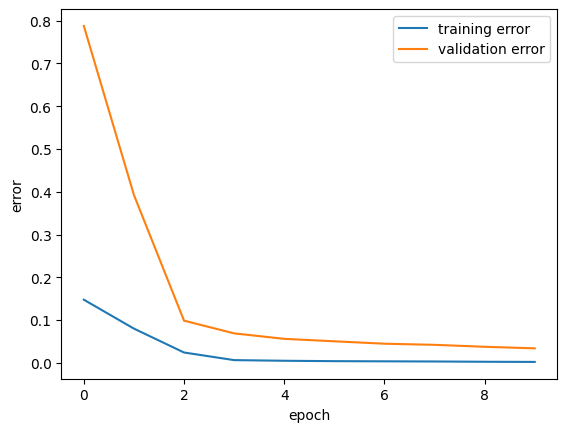

In [113]:
plt.plot(train, label="training error")
plt.plot(val, label="validation error")
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()
plt.show()

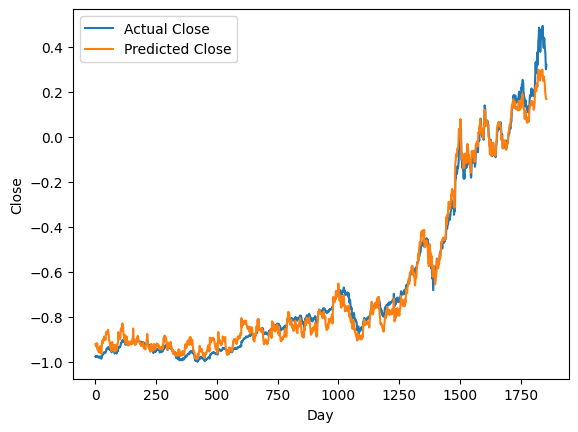

In [114]:
with torch.no_grad():
    predicted = model(X_train).to('cpu').numpy()

plt.plot(y_train.cpu(), label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [115]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], num_of_features+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 31.41031965,  31.24983963,  30.49623631, ..., 148.84010224,
       148.34510257, 148.07704614])

In [116]:
dummies = np.zeros((X_train.shape[0], num_of_features+1))
dummies[:, 0] = y_train.cpu().flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 25.54749785,  25.76250377,  25.31499791, ..., 162.3000043 ,
       162.75999357, 164.39000006])

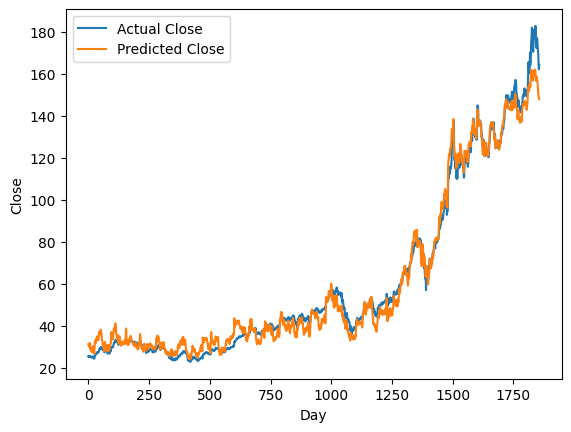

In [117]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [118]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], num_of_features+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([153.1165472 , 158.28445911, 158.87840953, 159.31395253,
       158.31219789, 157.51153508, 157.10522543, 158.24253797,
       159.40627356, 157.9876292 , 155.61363503, 154.94159383,
       156.64251849, 157.38979228, 155.80832068, 154.2749241 ,
       152.56227289, 149.86477027, 150.16406875, 151.99752707,
       152.64923842, 151.86004667, 152.91326783, 153.68777584,
       152.19627485, 149.61652954, 147.81234289, 150.0730347 ,
       149.64845501, 146.76321261, 143.88159804, 145.4366881 ,
       149.00534696, 150.53803777, 152.19956097, 153.50368943,
       155.22941166, 156.39913189, 158.25906436, 159.0515486 ,
       159.53507401, 160.97867881, 160.90161953, 159.53905312,
       158.88997321, 160.46222836, 159.67377751, 157.79955091,
       157.33229003, 156.53546581, 154.23221735, 154.09007125,
       155.66321739, 153.97628986, 152.77862966, 153.74610202,
       154.21658834, 153.82711805, 151.56584821, 151.01376464,
       148.48384439, 147.06160734, 150.37293995, 149.62

In [119]:
dummies = np.zeros((X_test.shape[0], num_of_features+1))
dummies[:, 0] = y_test.cpu().flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([163.83999546, 170.35000661, 174.99999905, 174.83999487,
       175.8800045 , 176.24000513, 174.10000546, 173.94999695,
       175.35000721, 176.6499937 , 175.47999564, 173.08000314,
       169.58000144, 172.94999555, 173.33999597, 171.91000508,
       170.53999461, 166.69000392, 166.14999499, 162.8500057 ,
       165.1199938 , 165.41999805, 166.60000456, 167.36000128,
       168.91000408, 165.55000245, 165.02000516, 162.88000549,
       163.41000278, 160.39000086, 159.27999918, 154.11999439,
       155.57000696, 160.00000044, 160.99999865, 164.47999623,
       166.3500074 , 169.41999726, 172.63999882, 174.14000092,
       175.27999919, 175.72999599, 179.00999393, 179.60999924,
       178.02999984, 174.8800063 , 178.49000508, 178.30000431,
       173.63000455, 173.36000008, 171.77999749, 169.03000003,
       169.86999405, 171.03999211, 171.27000431, 166.60000456,
       167.82000652, 168.8800043 , 171.53000034, 167.86999445,
       163.1699981 , 162.33999656, 159.78999236, 164.52

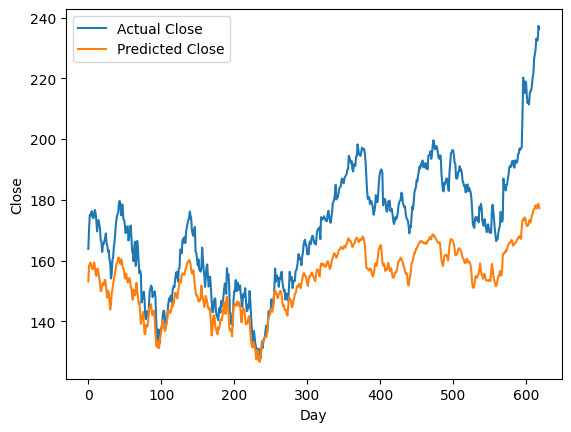

In [120]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [121]:
predicted_price = test_predictions[-1]

In [122]:
def evaluate_model(model, X_test: torch.Tensor, y_test: torch.Tensor):
    # Ensure the model is in evaluation mode
    model.eval()

    # Perform the forward pass
    with torch.no_grad():
        predictions: torch.Tensor = model(X_test)

    # Detach the predictions tensor and convert to numpy
    predictions_np = predictions.detach().cpu().numpy()

    return mean_squared_error(y_test.cpu(), predictions_np)

mse = evaluate_model(model, X_test, y_test)

In [123]:
def get_current_price(symbol:str):
    todays_data = yf.Ticker(symbol).history(period='1d')
    return todays_data['Close'].iloc[0]

current_price = get_current_price(ticker)

In [124]:
print(f'{ticker} Stock Prices')
print(f'\nStock Price Now: {current_price: 0.2f}')
print(f'Predicted Stock Price: {predicted_price: 0.2f}')
print(f'Mean Squared Error on Test Data: {mse: 0.2f}')

AAPL Stock Prices

Stock Price Now:  228.39
Predicted Stock Price:  177.21
Mean Squared Error on Test Data:  0.03
